In [1]:
This notebook is the from_weights.ipynb plotter but for the transformer model
import os
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import submitit

from tensorflow.keras import layers, models
from loss import custom_loss

from OptimizedDataGenerator import OptimizedDataGenerator
from loss import *
from models import *

pi = 3.14159265359

maxval=1e9
minval=1e-9

2025-04-30 20:52:46.539899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-30 20:52:46.539978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-30 20:52:46.541041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-30 20:52:46.548986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 20:52:59.382221: W tensorflow/compiler/tf2

In [2]:
class PatchExtractor(layers.Layer):
  """Extract 2D patches from images."""
  def __init__(self, patch_size=(3,7)):
    super().__init__()
    self.patch_size = patch_size

  def call(self, images):
    patch_h, patch_w = self.patch_size
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=(1, patch_h, patch_w, 1),
        strides=(1, patch_h, patch_w, 1),
        rates=(1,1,1,1),
        padding='VALID'
    )
    patch_dims = tf.shape(patches)[-1]
    patches = tf.reshape(
        patches,
        [batch_size, -1, patch_dims]
    )
    return patches

class PatchEncoder(layers.Layer):
  """Linear embedding + learnable positional encoding."""
  def __init__(self, num_patches, embed_dim):
    super().__init__()
    self.num_patches = num_patches
    self.projection  = layers.Dense(embed_dim)
    self.pos_embed   = tf.Variable(
        initial_value=tf.zeros((1,num_patches,embed_dim)),
        trainable=True,
        name="pos_embedding"
    )

  def call(self, patch_batch):
    projected = self.projection(patch_batch)
    return projected + self.pos_embed

def transformer_encoder(inputs,
                        head_size,
                        num_heads,
                        ff_dim,
                        dropout=0.1):
  # LayerNorm + Multi-head attention
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(num_heads=num_heads,
                                key_dim=head_size,
                                dropout=dropout)(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs
  
  # LN + feed-forward (mlp)
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Dense(ff_dim, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Dense(inputs.shape[-1], activation="linear")(x)
  x = layers.Dropout(dropout)(x)
  
  return x + res

def create_vit_model(input_shape=(13,21,2),
                     patch_size=(3,7),
                     embed_dim=64,
                     num_heads=4,
                     ff_dim=128,
                     num_layers=4,
                     dropout=0.1,
                     final_outputs=14):
  inputs = layers.Input(shape=input_shape)
  patches = PatchExtractor(patch_size=patch_size)(inputs)
  
  H, W, C = input_shape
  ph, pw  = patch_size
  num_patches = (H // ph) * (W // pw)

  encoded_patches = PatchEncoder(num_patches, embed_dim)(patches)

  x = encoded_patches
  for _ in range(num_layers):
    x = transformer_encoder(x,
                            head_size=embed_dim,
                            num_heads=num_heads,
                            ff_dim=ff_dim,
                            dropout=dropout)
  
  x = layers.LayerNormalization(epsilon=1e-6)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, activation='relu')(x)
  outputs = layers.Dense(final_outputs, activation='linear')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

model = create_vit_model(
    input_shape=(13,21,2),   
    patch_size=(3,7),        
    embed_dim=64,            
    num_heads=4,             
    ff_dim=128,              
    num_layers=4,           
    dropout=0.1,             
    final_outputs=14         
)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, 21, 2)]          0         []                            
                                                                                                  
 patch_extractor (PatchExtr  (None, None, 42)             0         ['input_1[0][0]']             
 actor)                                                                                           
                                                                                                  
 patch_encoder (PatchEncode  (None, 12, 64)               3520      ['patch_extractor[0][0]']     
 r)                                                                                               
                                                                                              

In [3]:
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
    loss=custom_loss
)

In [4]:
print(os.getcwd())
print("Subcarpetas y archivos:")
print(os.listdir('./model_batchnorm'))

/home/callea/smart-pixels-ml
Subcarpetas y archivos:
['weights-50x12P5x100_bnorm-checkpoints', 'models_bnorm.py', '.ipynb_checkpoints']


In [5]:
fingerprint = '0f649086'
base_dir = f'./trained_models/model-{fingerprint}-checkpoints'
checkpoint_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.hdf5')]
latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
training_cp_path = os.path.join(base_dir, 'training_log.csv')
training_history = pd.read_csv(training_cp_path)

In [6]:
print(f"Loading model from {latest_checkpoint}")
model.load_weights(latest_checkpoint)

Loading model from ./trained_models/model-0f649086-checkpoints/weights.95-t-41495.22-v-43970.85.hdf5


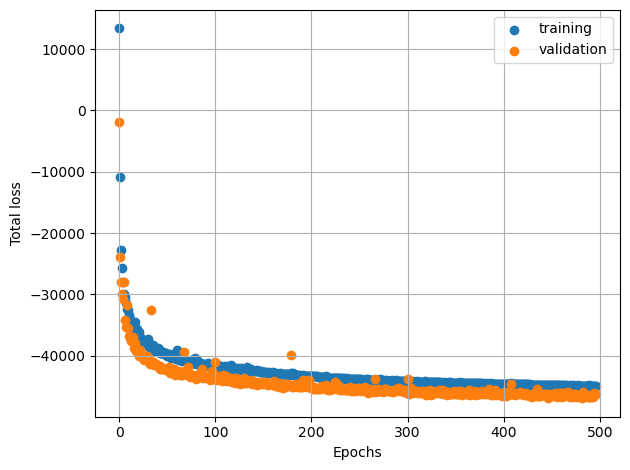

In [7]:
plt.scatter(training_history['epoch'], training_history['loss'])
plt.scatter(training_history['epoch'], training_history['val_loss'])
plt.legend(['training', 'validation'])
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Total loss')
plt.tight_layout() 

plt.savefig(os.path.join(base_dir,'training_hist.png'))
plt.show()

In [8]:
training_history

,epoch,loss,val_loss
0,0,13376.228516,-1835.835938
1,1,-10932.859375,-23841.685547
2,2,-22700.052734,-28022.220703
3,3,-25761.417969,-29904.744141
4,4,-27932.564453,-30720.603516
...,...,...,...
492,492,-44946.847656,-46793.746094
493,493,-44958.160156,-46721.875000
494,494,-44983.562500,-46157.246094
495,495,-44937.507812,-46214.421875


In [9]:
import OptimizedDataGenerator as DG

tfrecords_dir_val = "/depot/cms/users/das214/tfrecords_2t_val_d8"
test_generator = DG.OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_val,
    quantize = True
)

In [10]:
# predicts test data
p_test = model.predict(test_generator)

2025-04-30 20:54:05.185631: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


59/59 [==============================] - 5s 70ms/step


In [11]:
complete_truth = None
for _, y in tqdm(test_generator):
        if complete_truth is None:
            complete_truth = y
        else:
            complete_truth = np.concatenate((complete_truth, y), axis=0)

100%|██████████| 59/59 [00:03<00:00, 15.35it/s]


In [12]:
# creates df with all predicted values and matrix elements - 4 predictions, all 10 unique matrix elements
df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])

# stores all true values in same matrix as xtrue, ytrue, etc.
df['xtrue'] = complete_truth[:,0]
df['ytrue'] = complete_truth[:,1]
df['cotAtrue'] = complete_truth[:,2]
df['cotBtrue'] = complete_truth[:,3]
df['M11'] = minval+tf.math.maximum(df['M11'], 0)
df['M22'] = minval+tf.math.maximum(df['M22'], 0)
df['M33'] = minval+tf.math.maximum(df['M33'], 0)
df['M44'] = minval+tf.math.maximum(df['M44'], 0)

df['sigmax'] = abs(df['M11'])
df['sigmay'] = np.sqrt(df['M21']**2 + df['M22']**2)
df['sigmacotA'] = np.sqrt(df['M31']**2+df['M32']**2+df['M33']**2)
df['sigmacotB'] = np.sqrt(df['M41']**2+df['M42']**2+df['M43']**2+df['M44']**2)

# calculates residuals for x, y, cotA, cotB
residuals = df['xtrue'] - df['x']
residualsy = df['ytrue'] - df['y']
residualsA = df['cotAtrue'] - df['cotA']
residualsB = df['cotBtrue'] - df['cotB']

# stores results as csv
df.to_csv("test_4x4.csv",header=True,index=False)

# residuals (mean, stdv)

In [13]:
# x
(np.mean(residuals)*75,np.std(residuals)*75)

(0.14811849687248468, 4.398056678473949)

In [14]:
# y
(np.mean(residualsy)*18.75,np.std(residualsy)*18.75)

(-0.06339355604723096, 0.8079595863819122)

In [15]:
# cotA
(np.mean(residualsA)*8,np.std(residualsA)*8)

(0.008750442415475845, 0.11947199702262878)

In [16]:
# cotB
(np.mean(residualsB)*0.5,np.std(residualsB)*0.5)

(-0.0001905408571474254, 0.02290056087076664)

# x residuals

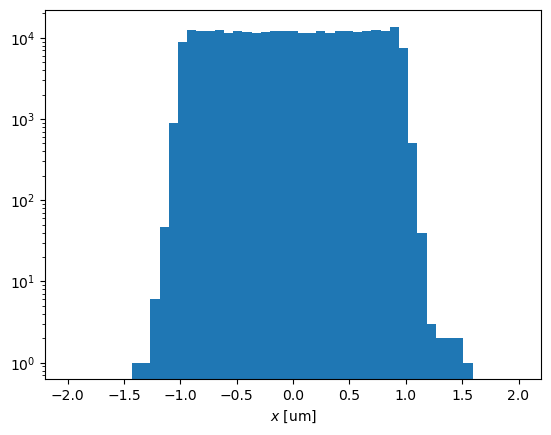

In [17]:
plt.hist(p_test[:,0],bins=np.linspace(-2,2,50))
plt.yscale('log')
plt.xlabel(r'$x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_dist.png')
plt.savefig(save_fig_path)

plt.show()

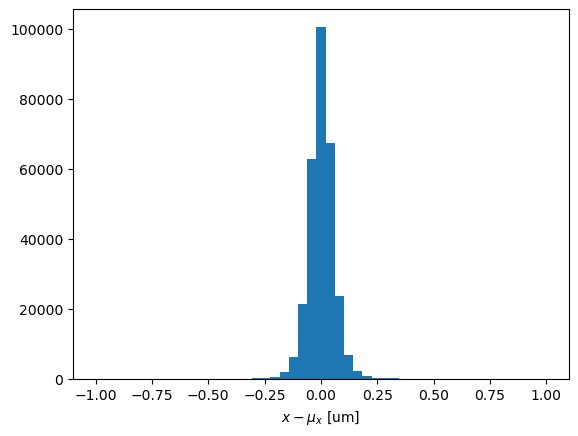

In [18]:
plt.hist(residuals,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

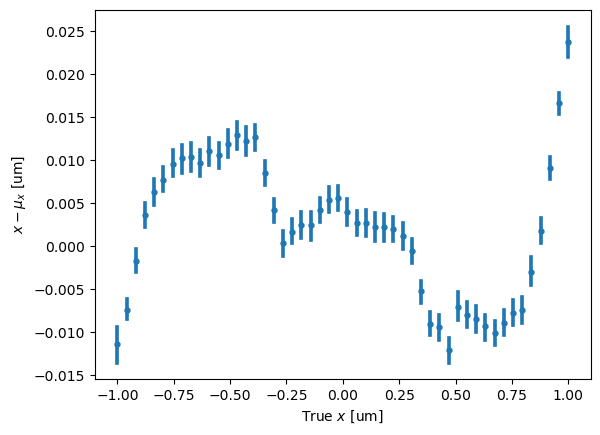

In [19]:
x = sns.regplot(x=df['xtrue'], y=(df['xtrue']-df['x']), x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# y residuals

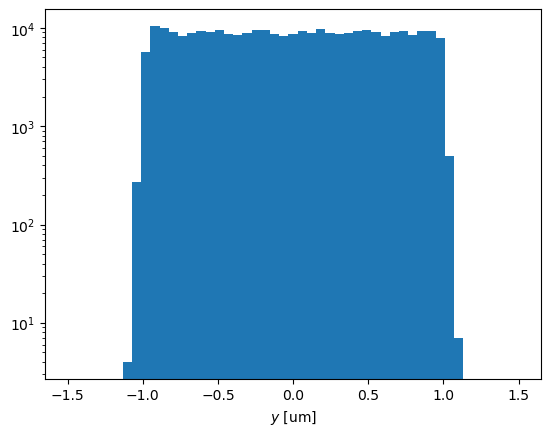

In [20]:
plt.hist(p_test[:,2],bins=np.linspace(-1.5,1.5,50))
plt.yscale('log')
plt.xlabel(r'$y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_dist.png')
plt.savefig(save_fig_path)

plt.show()

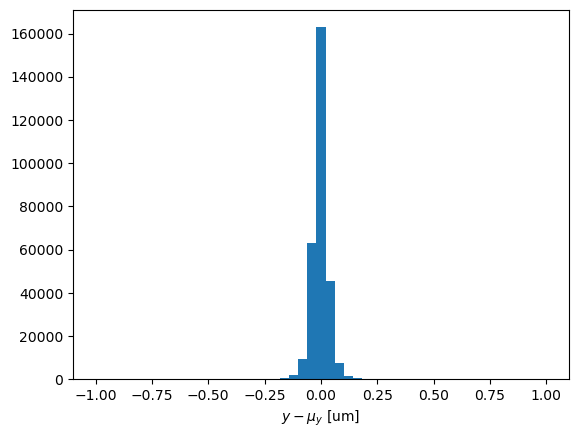

In [21]:
plt.hist(residualsy,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

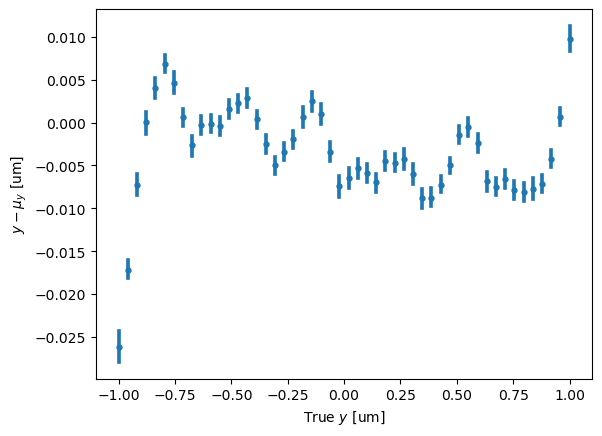

In [22]:
x = sns.regplot(x=df['ytrue'], y=(df['ytrue']-df['y']), x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.')
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotA residuals

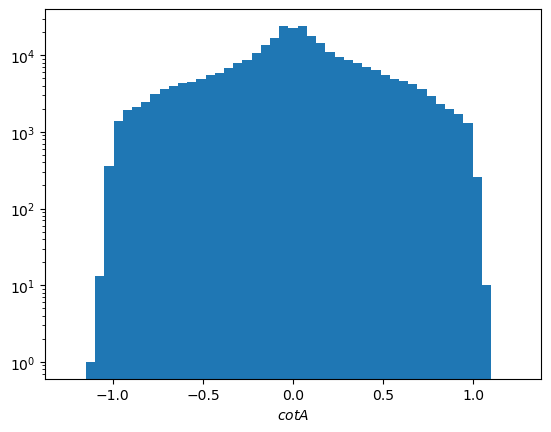

In [23]:
plt.hist(p_test[:,4],bins=np.linspace(-1.25,1.25,50))
plt.yscale('log')
plt.xlabel(r'$cotA$')

save_fig_path = os.path.join(base_dir, 'cotA_dist.png')
plt.savefig(save_fig_path)

plt.show()

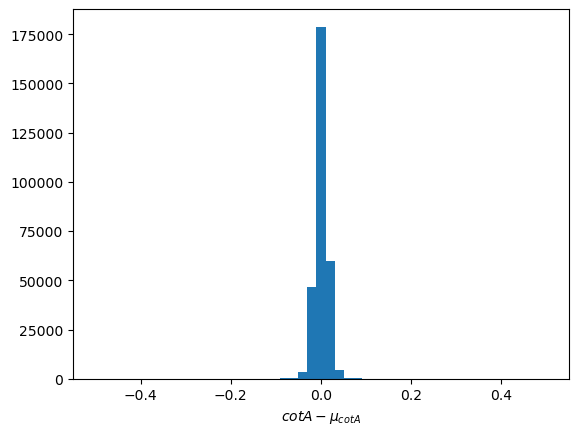

In [24]:
plt.hist(residualsA,bins=np.linspace(-0.5,0.5,50))
#plt.yscale('Log')
plt.xlabel(r'$cotA-\mu_{cotA}$')

save_fig_path = os.path.join(base_dir, 'cotA_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

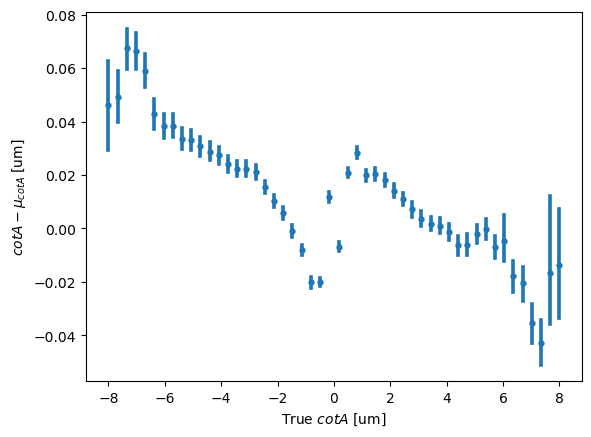

In [25]:
x = sns.regplot(x=df['cotAtrue']*8, y=(df['cotAtrue']-df['cotA'])*8, x_bins=np.linspace(-8,8,50), fit_reg=None, marker='.')
plt.xlabel(r'True $cotA$ [um]')
plt.ylabel(r'$cotA-\mu_{cotA}$ [um]')

save_fig_path = os.path.join(base_dir, 'cotA_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotB residuals

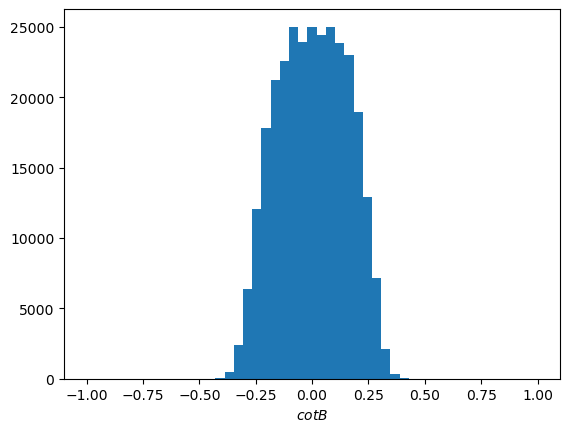

In [26]:
plt.hist(p_test[:,6]*0.5,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$cotB$')

save_fig_path = os.path.join(base_dir, 'cotB_dist.png')
plt.savefig(save_fig_path)

plt.show()

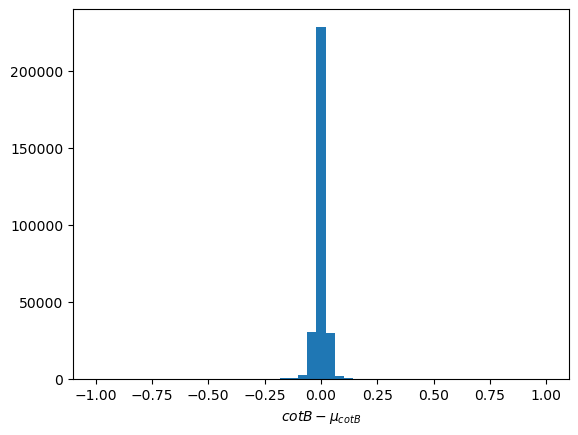

In [27]:
plt.hist(residualsB*0.5,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$cotB-\mu_{cotB}$')

save_fig_path = os.path.join(base_dir, 'cotB_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

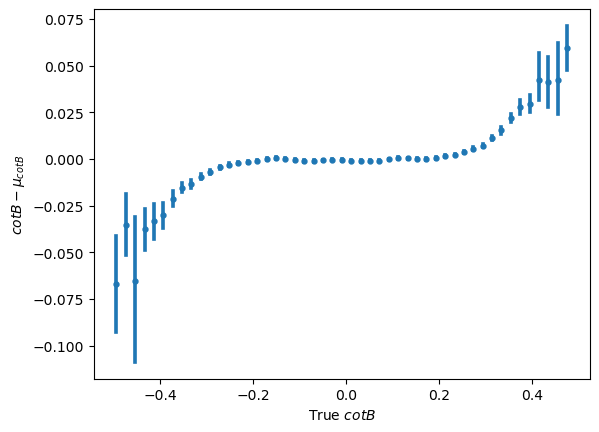

In [28]:
x = sns.regplot(x=df['cotBtrue']*0.5, y=(df['cotBtrue']-df['cotB'])*0.5, x_bins=np.linspace(-1,1,100), fit_reg=None, marker='.')
plt.xlabel(r'True $cotB$')
plt.ylabel(r'$cotB-\mu_{cotB} $')

save_fig_path = os.path.join(base_dir, 'cotB_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# pull

In [29]:
df['pullx'] = (df['xtrue']-df['x'])/df['sigmax']
df['pully'] = (df['ytrue']-df['y'])/df['sigmay']
df['pullcotA'] = (df['cotAtrue']-df['cotA'])/df['sigmacotA']
df['pullcotB'] = (df['cotBtrue']-df['cotB'])/df['sigmacotB']

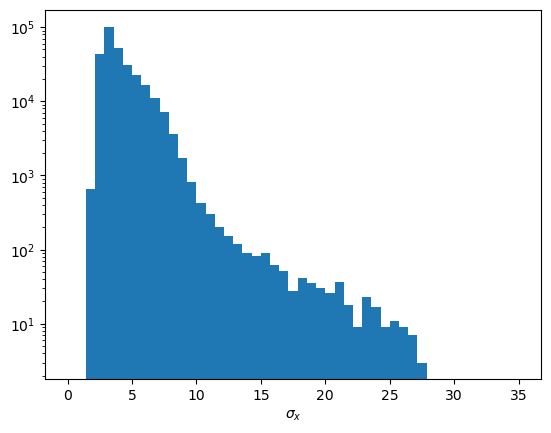

In [30]:
plt.hist(df['sigmax'] * 75,bins=np.linspace(0,35,50))
plt.xlabel('$\sigma_{x}$')
plt.yscale('log')

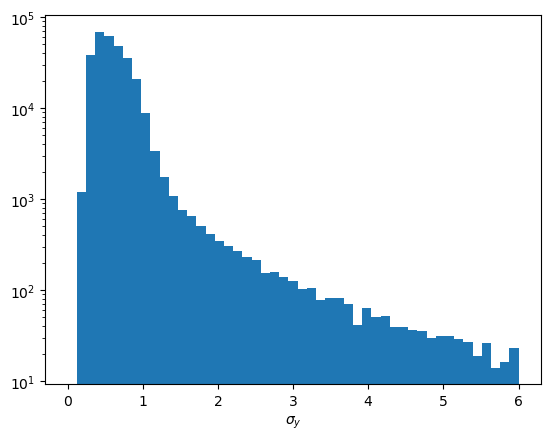

In [31]:
plt.hist(df['sigmay']* 18.75,bins=np.linspace(0,6,50))
plt.xlabel('$\sigma_{y}$')
plt.yscale('log')

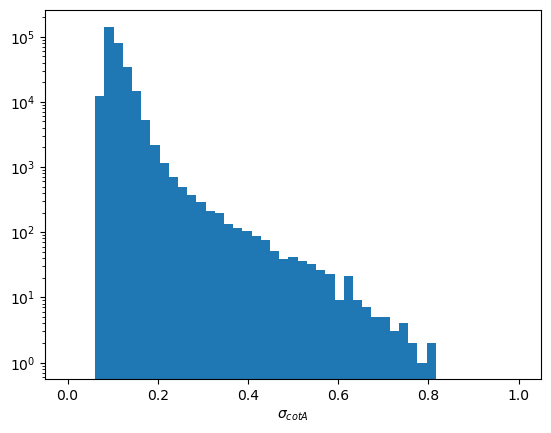

In [32]:
plt.hist(df['sigmacotA'] * 8,bins=np.linspace(0,1.0,50))
plt.xlabel('$\sigma_{cotA}$')
plt.yscale('log')

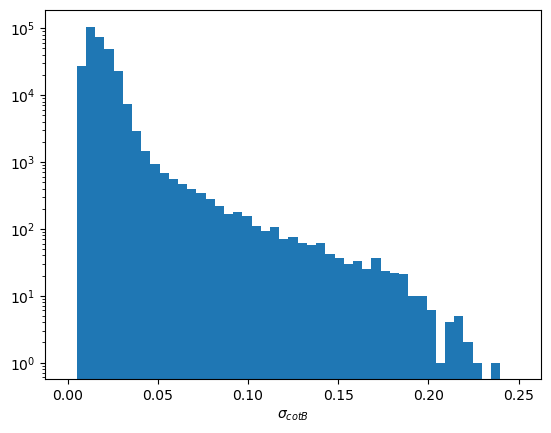

In [33]:
plt.hist(df['sigmacotB'] * 0.5 ,bins=np.linspace(0,0.25,50))
plt.xlabel('$\sigma_{cotB}$')
plt.yscale('log')

In [34]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def pull_plot(ax, var, name, unit_gauss = True, log_scale = True):
    
    h = ax.hist(df[var],bins=np.linspace(-10,10,50),histtype='step')
    ax.set_xlabel(name)
    if log_scale: ax.set_yscale('log')

    ydata = h[0]
    xdata = h[1][:-1]+3/50.

    pars, cov = curve_fit(gauss,xdata,ydata)

    xbins = np.linspace(-10,10,100)
    ax.plot(xbins,gauss(xbins,pars[0],pars[1],pars[2]),color='black', label='Fitted Gaussian')
    if unit_gauss: ax.plot(xbins,gauss(xbins,pars[0],0, 1),color='red', label='Unit Gaussian')
    ax.set_ylim(0.5,100000)

    print('Mean',pars[1])
    print('Sigma',pars[2])
    
    ax.text(-10,20000,"$\mu$="+str(round(pars[1],2)))
    ax.text(-10,10000,"$\sigma$="+str(round(abs(pars[2]),2)))

    ax.legend()


Mean -0.10797516931857495
Sigma 0.9277531748938902
Mean -0.27956222625115373
Sigma 0.901070524961482
Mean -0.06270133350955556
Sigma -0.8956936973450438
Mean -0.1167912623101933
Sigma 0.9258931762390274


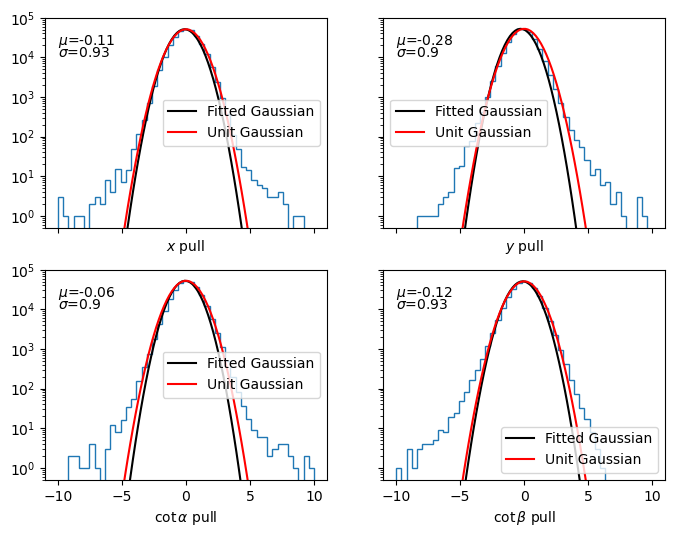

In [35]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
pull_plot(axes[0][0],'pullx',r'$x$ pull')
pull_plot(axes[0][1],'pully',r'$y$ pull')
pull_plot(axes[1][0],'pullcotA',r'$\cot\alpha$ pull')
pull_plot(axes[1][1],'pullcotB',r'$\cot\beta$ pull')

save_fig_path = os.path.join(base_dir, 'Pull.png')
plt.savefig(save_fig_path)

plt.show()

In [36]:
def residual_plot(ax, thisdf, var1, var2, name, scaling=1.0):
    
    nbins = 15
    
    var1_scaled = thisdf[var1] * scaling
    var2_scaled = thisdf[var2] * scaling
    residual_scaled = var1_scaled - var2_scaled
    
    xmin = np.min(var1_scaled)
    xmax = np.max(var1_scaled)
    
    step = 1.0*(xmax-xmin)/nbins
    
    x = sns.regplot(x=var1_scaled, y=residual_scaled, x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = residual_scaled
    print(var1)
    
    means = []
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
        downbar += [means[i] - np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

def inverse_cot(cota):
    a = np.arctan(1.0/cota)
    a[np.where(a<0)] = a[np.where(a<0)] + pi
    return a    

def residual_plot_deg(ax, thisdf, var1, var2, name, scaling=1.0):
    # positions
    if 'cot' not in var1:
        residual_plot(ax, thisdf, var1, var2, name, scaling=scaling)
        return

    thisdf['angle'] = inverse_cot(thisdf[var2].values * scaling)*180/pi
    
    thisdf['angleup'] = abs(inverse_cot((thisdf[var2].values + thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angledown'] = abs(inverse_cot((thisdf[var2].values - thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angletrue'] = inverse_cot(thisdf[var1].values * scaling)*180/pi
        
    var1 = 'angletrue'
    var2 = 'angle'
    
    nbins = 15
    xmin = np.min(thisdf[var1])
    xmax = np.max(thisdf[var1])
    
    step = 1.0*(xmax-xmin)/nbins
        
    x = sns.regplot(x=thisdf[var1], y=(thisdf[var1]-thisdf[var2]), x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = (thisdf[var1]-thisdf[var2])
    print(var1)
    
    means = []    
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['angleup'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        downbar += [means[i] - np.mean(thisdf['angledown'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
    #ax.scatter(x=np.linspace(xmin,xmax,nbins),y=means)
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

xtrue
ytrue
angletrue


/tmp/ipykernel_143066/2844183014.py:31: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


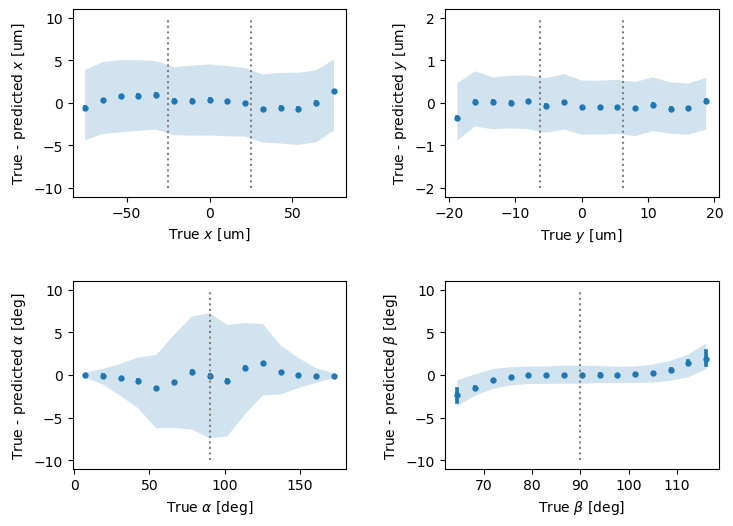

In [37]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout(pad=4.0)
residual_plot(axes[0][0],df,'xtrue','x',r'$x$ [um]', scaling=75.0)
axes[0][0].plot([-25,-25],[-10,10],color='gray',linestyle=':')
axes[0][0].plot([25,25],[-10,10],color='gray',linestyle=':')
residual_plot(axes[0][1],df,'ytrue','y',r'$y$ [um]', scaling=18.75)
axes[0][1].plot([-6.25,-6.25],[-2,2],color='gray',linestyle=':')
axes[0][1].plot([6.25,6.25],[-2,2],color='gray',linestyle=':')
residual_plot_deg(axes[1][0],df,'cotAtrue','cotA',r'$\alpha$ [deg]', scaling=8.0)
axes[1][0].plot([90,90],[-10,10],color='gray',linestyle=':')
residual_plot_deg(axes[1][1],df,'cotBtrue','cotB',r'$\beta$ [deg]', scaling=0.5)
axes[1][1].plot([90,90],[-10,10],color='gray',linestyle=':')

save_fig_path = os.path.join(base_dir, 'summary.png')
plt.savefig(save_fig_path)